### The code below searches for parameters that are better than the Control parameters generally across different time-windows

In [24]:
# Importing Libraries
import pandas as pd
import numpy as np
from fbprophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from fbprophet.plot import add_changepoints_to_plot
from sklearn.metrics import *
import seaborn as sns
from fbprophet.diagnostics import cross_validation
from sklearn.metrics import mean_absolute_error
from pylab import figure, axes, pie, title, show
import random
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
import sys

In [25]:
#Functions
def error_measures(actual, predicted):
    r2 = r2_score(y_true=actual, y_pred=predicted)
    rmse = np.sqrt(mean_squared_error(y_true=actual,y_pred=predicted))
    return r2, rmse

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(A, F):
    A = np.array(A)
    F = np.array(F)
    return (100/len(A)) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

def exp_decay(size, a, r):
    exponents = np.array(range(size))
    return (a*(r**exponents))

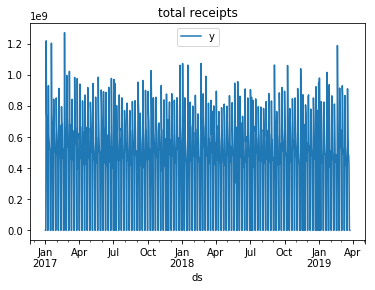

In [26]:
#Read Truth Data (Reading Total Receipts here. Can be changed)
df = pd.read_csv("/Users/mw167d/Projects/FCF/2019-03-25_2019-03-24_receipts.csv",sep="|").rename(columns={'date': 'ds', 'amount': 'y'})
df['ds'] = pd.to_datetime(df.ds, format='%Y-%m-%d')
df.set_index('ds').plot(title="total receipts")

In [27]:
# get list of bank holidays (days where total receipts are recorded as 0)
bank_holidays_df = pd.read_csv("/Users/mw167d/Projects/FCF/US_bank_holiday.txt", sep='|').rename(columns=str.lower)
bank_holidays_df['week_day'] = pd.to_datetime(bank_holidays_df['date']).dt.day_name()

holidays_df = bank_holidays_df \
.query('week_day not in ["Saturday", "Sunday"]') \
.assign(holiday = lambda x: np.where(x.week_day=='Monday', 'monday_holiday', 'holiday'), \
lower_window = -2, \
upper_window = 4) \
.rename(columns={'date': 'ds'}) \
.drop(columns=['week_day'])

INFO:fbprophet.diagnostics:Making 8 forecasts with cutoffs between 2018-05-28 00:00:00 and 2018-12-24 00:00:00


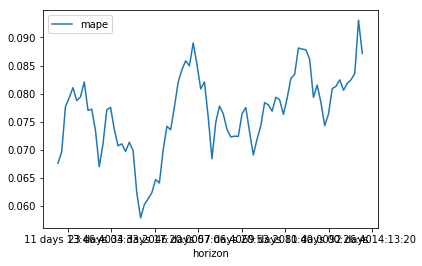

In [28]:
#How Control model looks like
control_parameters={"seasonality_prior_scale": 0.1, "holidays_prior_scale": 10,\
                  "weekly_seasonality": 50, "yearly_seasonality": 20,\
                  "daily_seasonality": False, "seasonality_mode": "multiplicative",\
                  "changepoint_prior_scale": 0.05}

control = Prophet(**control_parameters, holidays=holidays_df)

control.fit(df)

control_cv = cross_validation(control, initial='485 days', period='30 days', horizon = '90 days')


control_cv_perf = performance_metrics(df=control_cv[control_cv.y!=0], metrics=['mape'], rolling_window=0.1)
control_cv_perf_means = control_cv_perf.groupby('horizon').mean()
control_cv_perf_means.plot()

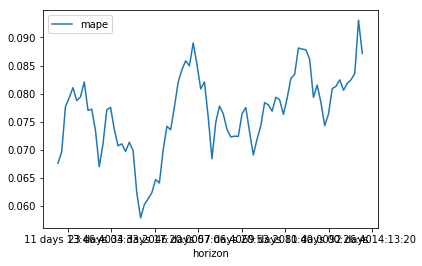

In [54]:
control_cv_perf_means.plot()
plt.savefig("Control")

In [70]:
#Initialize parameter searching space
ys = list(range(1,50,5)) #yearly_seasonality
hps = [0.001, 0.01, 0.1, 1, 10, 100] #list(range(1,50,5)) #holidays_prior_scale
ws = list(range(1,50,5)) #weekly_seasonality
sm = ["multiplicative", "additive"] #seasonality_mode
cpps = [0.001, 0.01, 0.1, 1, 10, 100] #changepoint_prior_scale
sps = [0.001, 0.01, 0.1, 1, 10, 100, 1000] #seasonality_prior_scale - np.arange(0.05,1,0.05)
ncp = list(range(1,50,5)) #n_changepoints=25

In [68]:
ys = [31] #yearly_seasonality
hps = [10] #list(range(1,50,5)) #holidays_prior_scale
ws = [6] #weekly_seasonality
sm = ["additive"] #seasonality_mode
cpps = [0.01] #changepoint_prior_scale
sps = [100] #seasonality_prior_scale - np.arange(0.05,1,0.05)
#ncp = list(range(1,50,5)) #n_changepoints=25

INFO:fbprophet.diagnostics:Making 8 forecasts with cutoffs between 2018-05-28 00:00:00 and 2018-12-24 00:00:00



---Iteration 0---
{'seasonality_prior_scale': 100, 'holidays_prior_scale': 10, 'weekly_seasonality': 6, 'yearly_seasonality': 31, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'n_changepoints': 41}
Metric 0.0033


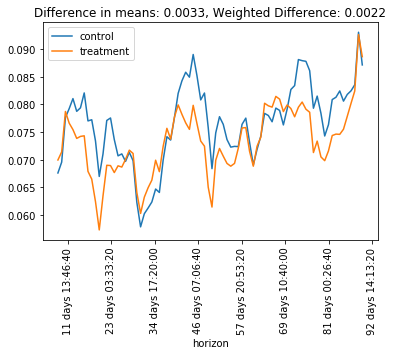

<Figure size 432x288 with 0 Axes>

In [69]:
iterations = []
for i in range(1): #enter how many iterations you want
    search_parameters = control_parameters.copy()

    #Randomly choosing parameters from the grid space
    search_parameters.update({"yearly_seasonality":np.random.choice(ys)})
    search_parameters.update({"weekly_seasonality":np.random.choice(ws)})
    search_parameters.update({"holidays_prior_scale":np.random.choice(hps)})
    search_parameters.update({"seasonality_mode":np.random.choice(sm)})
    search_parameters.update({"changepoint_prior_scale":np.random.choice(cpps)})
    search_parameters.update({"seasonality_prior_scale":np.random.choice(sps)})
    search_parameters.update({"n_changepoints":np.random.choice(ncp)})

    #Printing the chosen parameters
    #print(search_parameters)

    #Fitting the treatment model
    treatment = Prophet(**search_parameters, holidays=holidays_df)
    treatment.fit(df)

    #Calculating the CV'ed df
    treatment_cv = cross_validation(treatment, initial='485 days', period='30 days', horizon = '90 days')

    #Calculating CV performance metrics
    treatment_cv_perf = performance_metrics(df=treatment_cv[treatment_cv.y!=0], metrics=['mape'], rolling_window=0.1)
    treatment_cv_perf_means = treatment_cv_perf.groupby('horizon').mean()
    #plt.plot(treatment_cv_perf_means)
    
    element_wise_difference = (control_cv_perf_means.values[:,0] - treatment_cv_perf_means.values[:,0])
    decay = exp_decay(control_cv_perf_means.shape[0], 1, 0.99) #gives more importance to the days close to the forecast-on day
    diff_mean = round(np.mean(element_wise_difference),4) #Calculate the difference in means
    wgted_diff_mean = round(np.mean(element_wise_difference*decay),4) #Calculate diff_mean weight by exp decay
    
    print("\n---Iteration {}---".format(i))
    print(search_parameters)
    print("Metric {}".format(diff_mean))
    
    iterations.append({"Parameters":search_parameters, "diff_mean":diff_mean, "wgted_diff_mean":wgted_diff_mean})
    
    fig, ax = plt.subplots()
    control_cv_perf_means.plot(ax=ax,sharex=True, title="Difference in means: {}, Weighted Difference: {}".format(diff_mean, wgted_diff_mean))
    treatment_cv_perf_means.plot(ax=ax, sharex=True, rot=90)
    ax.legend(["control", "treatment"]);
    plt.show()
    plt.figure()

In [31]:
pd.DataFrame(iterations).sort_values('diff_mean') #Chose the parameter based on this

,Parameters,diff_mean,wgted_diff_mean
1,"{'seasonality_prior_scale': 10.0, 'holidays_pr...",-0.0040,-0.0024
0,"{'seasonality_prior_scale': 0.1, 'holidays_pri...",-0.0016,-0.0014


In [38]:
iters = pd.DataFrame(iterations)

In [64]:
iters.to_csv(path_or_buf="iterations_RFO_average_comparison")

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


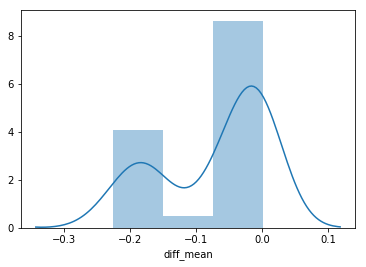

In [61]:
sns.distplot(iters.diff_mean, norm_hist=False)
plt.savefig("Density")

In [52]:
iters.ix[iters.diff_mean >0]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


,Parameters,diff_mean,wgted_diff_mean
27,"{'seasonality_prior_scale': 1000.0, 'holidays_...",0.0010,0.0008
36,"{'seasonality_prior_scale': 100.0, 'holidays_p...",0.0006,0.0004
49,"{'seasonality_prior_scale': 1.0, 'holidays_pri...",0.0006,0.0003


In [55]:
iters.to_pickle("Iterations")